# NCAA competition + AI Lithuania workshop

![bracket](https://www.ncaa.com/_flysystem/public-s3/images/2025-01/2025-ncaa-tournament-bracket-march-madness-mens.jpg)

## <<- Data format explained ->>

![box score](https://cdn.geekwire.com/wp-content/uploads/2019/01/boxscore11-e1546622261885.png)

## <<- Load the data ->>

In [3]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from scipy.interpolate import UnivariateSpline
import warnings
warnings.filterwarnings("ignore")

warnings.filterwarnings("ignore")
pd.set_option("display.max_column", 999)
data_dir = "/Users/nicholasrichards/Desktop/march_madness_prediction_project/march-machine-learning-mania-2025"

# W -> women's basketball, M -> men's basketball
M_regular_results = pd.read_csv(f"{data_dir}/MRegularSeasonDetailedResults.csv")
M_tourney_results = pd.read_csv(f"{data_dir}/MNCAATourneyDetailedResults.csv")
M_seeds = pd.read_csv(f"{data_dir}/MNCAATourneySeeds.csv")

W_regular_results = pd.read_csv(f"{data_dir}/WRegularSeasonDetailedResults.csv")
W_tourney_results = pd.read_csv(f"{data_dir}/WNCAATourneyDetailedResults.csv")
W_seeds = pd.read_csv(f"{data_dir}/WNCAATourneySeeds.csv")

In [4]:
# join men's and women's data into one file
regular_results = pd.concat([M_regular_results, W_regular_results])
tourney_results = pd.concat([M_tourney_results, W_tourney_results])
seeds = pd.concat([M_seeds, W_seeds])

In [5]:
season = 2003  # change if you want different cutoff year for your models
regular_results = regular_results.loc[regular_results["Season"] >= season]
tourney_results = tourney_results.loc[tourney_results["Season"] >= season]
seeds = seeds.loc[seeds["Season"] >= season]

## <<- Explore the data ->>

In [6]:
regular_results

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,10,1104,68,1328,62,N,0,27,58,3,14,11,18,14,24,13,23,7,1,22,22,53,2,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,8,20,10,19,15,28,16,13,4,4,18,24,67,6,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,8,18,17,29,17,26,15,10,5,2,25,22,73,3,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,3,9,17,31,6,19,11,12,14,2,18,18,49,6,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,6,14,11,13,17,22,12,14,4,4,20,24,62,6,16,17,27,21,15,12,10,7,1,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81703,2025,131,3471,75,3413,66,A,0,26,62,4,19,19,28,8,31,10,11,6,1,20,24,67,9,29,9,14,9,26,14,10,6,5,22
81704,2025,132,3192,66,3476,49,H,0,23,55,3,21,17,18,10,22,11,9,8,1,8,21,57,4,20,3,4,14,22,14,17,4,1,17
81705,2025,132,3250,74,3119,62,H,0,27,45,5,14,15,17,5,25,15,15,6,0,12,25,56,6,17,6,10,8,13,10,10,5,0,20
81706,2025,132,3293,83,3125,62,N,0,28,54,14,28,13,15,5,33,21,13,2,3,15,24,68,2,21,12,14,12,22,11,7,5,0,16


In [7]:
tourney_results

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,134,1421,92,1411,84,N,1,32,69,11,29,17,26,14,30,17,12,5,3,22,29,67,12,31,14,31,17,28,16,15,5,0,22
1,2003,136,1112,80,1436,51,N,0,31,66,7,23,11,14,11,36,22,16,10,7,8,20,64,4,16,7,7,8,26,12,17,10,3,15
2,2003,136,1113,84,1272,71,N,0,31,59,6,14,16,22,10,27,18,9,7,4,19,25,69,7,28,14,21,20,22,11,12,2,5,18
3,2003,136,1141,79,1166,73,N,0,29,53,3,7,18,25,11,20,15,18,13,1,19,27,60,7,17,12,17,14,17,20,21,6,6,21
4,2003,136,1143,76,1301,74,N,1,27,64,7,20,15,23,18,20,17,13,8,2,14,25,56,9,21,15,20,10,26,16,14,5,8,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
889,2024,147,3163,80,3425,73,A,0,28,58,7,15,17,27,5,30,17,12,6,5,21,23,70,9,29,18,20,10,25,10,9,6,4,20
890,2024,147,3234,94,3261,87,H,0,32,69,13,31,17,22,3,29,16,11,6,3,15,34,88,8,24,11,17,21,28,15,13,6,6,21
891,2024,151,3234,71,3163,69,N,0,27,59,7,25,10,14,9,23,12,16,7,1,9,29,63,8,25,3,4,6,22,21,14,15,1,18
892,2024,151,3376,78,3301,59,N,0,33,66,8,19,4,4,10,34,18,15,10,6,16,20,62,6,23,13,18,10,18,5,12,9,1,9


In [8]:
# let's take one random team and see its journey during the 2024 season
season = 2024
teamid = 3163

r = regular_results.loc[
    (regular_results["Season"] == season)
    & ((regular_results["WTeamID"] == teamid) | (regular_results["LTeamID"] == teamid))
]
t = tourney_results.loc[
    (tourney_results["Season"] == season)
    & ((tourney_results["WTeamID"] == teamid) | (tourney_results["LTeamID"] == teamid))
]
r["win"] = np.where(r["WTeamID"] == teamid, "win", "lose")
t["win"] = np.where(t["WTeamID"] == teamid, "win", "lose")
r["type"] = "regular season"
t["type"] = "tournament"

rt = pd.concat([r, t])
rt[["DayNum", "WScore", "LScore", "type", "win"]]

,DayNum,WScore,LScore,type,win
70978,2,102,58,regular season,win
71162,6,92,81,regular season,lose
71309,10,80,48,regular season,win
71432,13,62,44,regular season,win
71679,18,78,67,regular season,lose
71703,19,71,63,regular season,win
72099,27,80,68,regular season,lose
72161,30,90,63,regular season,win
72306,34,76,64,regular season,win
72433,40,86,62,regular season,win


In [9]:
seeds

,Season,Seed,TeamID
1154,2003,W01,1328
1155,2003,W02,1448
1156,2003,W03,1393
1157,2003,W04,1257
1158,2003,W05,1280
...,...,...,...
1739,2025,Z12,3193
1740,2025,Z13,3251
1741,2025,Z14,3195
1742,2025,Z15,3117


In [10]:
# structure of seeds by division
s = W_seeds.loc[W_seeds["Season"] == 2015]
[s.loc[s["Seed"].str.startswith(d)] for d in ("X", "Y", "Z", "W")]

[      Season Seed  TeamID
 1104    2015  X01    3268
 1105    2015  X02    3397
 1106    2015  X03    3333
 1107    2015  X04    3181
 1108    2015  X05    3280
 1109    2015  X06    3203
 1110    2015  X07    3151
 1111    2015  X08    3343
 1112    2015  X09    3453
 1113    2015  X10    3338
 1114    2015  X11    3211
 1115    2015  X12    3408
 1116    2015  X13    3107
 1117    2015  X14    3355
 1118    2015  X15    3129
 1119    2015  X16    3308,
       Season Seed  TeamID
 1120    2015  Y01    3376
 1121    2015  Y02    3199
 1122    2015  Y03    3113
 1123    2015  Y04    3314
 1124    2015  Y05    3326
 1125    2015  Y06    3401
 1126    2015  Y07    3195
 1127    2015  Y08    3393
 1128    2015  Y09    3304
 1129    2015  Y10    3329
 1130    2015  Y11    3114
 1131    2015  Y12    3241
 1132    2015  Y13    3251
 1133    2015  Y14    3325
 1134    2015  Y15    3106
 1135    2015  Y16    3366,
       Season Seed  TeamID
 1136    2015  Z01    3323
 1137    2015  Z02    3124

In [11]:
# let's see what seed our previous example team had
seeds.loc[(seeds["Season"] == season) & (seeds["TeamID"] == teamid)]

,Season,Seed,TeamID
1660,2024,Z03,3163


## <<- Prepare the data ->>

In [12]:
# double the dataset with swapped team positions in box scores
def prepare_data(df):
    df = df[["Season", "DayNum", "LTeamID", "LScore", "WTeamID", "WScore", "NumOT",
            "LFGM", "LFGA", "LFGM3", "LFGA3", "LFTM", "LFTA", "LOR", "LDR", "LAst", "LTO", "LStl", "LBlk", "LPF",
            "WFGM", "WFGA", "WFGM3", "WFGA3", "WFTM", "WFTA", "WOR", "WDR", "WAst", "WTO", "WStl", "WBlk", "WPF"]]
    

    # adjustment factor for overtimes, as more stats are accumulated during overtimes
    adjot = (40 + 5 * df["NumOT"]) / 40
    adjcols = ["LScore", "WScore", 
               "LFGM", "LFGA", "LFGM3", "LFGA3", "LFTM", "LFTA", "LOR", "LDR", "LAst", "LTO", "LStl", "LBlk", "LPF",
               "WFGM", "WFGA", "WFGM3", "WFGA3", "WFTM", "WFTA", "WOR", "WDR", "WAst", "WTO", "WStl", "WBlk", "WPF"]
    for col in adjcols:
        df[col] = df[col] / adjot    
    
    dfswap = df.copy()
    df.columns = [x.replace("W", "T1_").replace("L", "T2_") for x in list(df.columns)]
    dfswap.columns = [x.replace("L", "T1_").replace("W", "T2_") for x in list(dfswap.columns)]
    output = pd.concat([df, dfswap]).reset_index(drop=True)
    output["PointDiff"] = output["T1_Score"] - output["T2_Score"]
    output["win"] = (output["PointDiff"] > 0) * 1
    output["men_women"] = (output["T1_TeamID"].apply(lambda t: str(t).startswith("1"))) * 1  # 0: women, 1: men
    return output

regular_data = prepare_data(regular_results)
tourney_data = prepare_data(tourney_results)

In [13]:
regular_data

,Season,DayNum,T2_TeamID,T2_Score,T1_TeamID,T1_Score,NumOT,T2_FGM,T2_FGA,T2_FGM3,T2_FGA3,T2_FTM,T2_FTA,T2_OR,T2_DR,T2_Ast,T2_TO,T2_Stl,T2_Blk,T2_PF,T1_FGM,T1_FGA,T1_FGM3,T1_FGA3,T1_FTM,T1_FTA,T1_OR,T1_DR,T1_Ast,T1_TO,T1_Stl,T1_Blk,T1_PF,PointDiff,win,men_women
0,2003,10,1328,62.0,1104,68.0,0,22.0,53.0,2.0,10.0,16.0,22.0,10.0,22.0,8.0,18.0,9.0,2.0,20.0,27.0,58.0,3.0,14.0,11.0,18.0,14.0,24.0,13.0,23.0,7.0,1.0,22.0,6.0,1,1
1,2003,10,1393,63.0,1272,70.0,0,24.0,67.0,6.0,24.0,9.0,20.0,20.0,25.0,7.0,12.0,8.0,6.0,16.0,26.0,62.0,8.0,20.0,10.0,19.0,15.0,28.0,16.0,13.0,4.0,4.0,18.0,7.0,1,1
2,2003,11,1437,61.0,1266,73.0,0,22.0,73.0,3.0,26.0,14.0,23.0,31.0,22.0,9.0,12.0,2.0,5.0,23.0,24.0,58.0,8.0,18.0,17.0,29.0,17.0,26.0,15.0,10.0,5.0,2.0,25.0,12.0,1,1
3,2003,11,1457,50.0,1296,56.0,0,18.0,49.0,6.0,22.0,8.0,15.0,17.0,20.0,9.0,19.0,4.0,3.0,23.0,18.0,38.0,3.0,9.0,17.0,31.0,6.0,19.0,11.0,12.0,14.0,2.0,18.0,6.0,1,1
4,2003,11,1208,71.0,1400,77.0,0,24.0,62.0,6.0,16.0,17.0,27.0,21.0,15.0,12.0,10.0,7.0,1.0,14.0,30.0,61.0,6.0,14.0,11.0,13.0,17.0,22.0,12.0,14.0,4.0,4.0,20.0,6.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401175,2025,131,3471,75.0,3413,66.0,0,26.0,62.0,4.0,19.0,19.0,28.0,8.0,31.0,10.0,11.0,6.0,1.0,20.0,24.0,67.0,9.0,29.0,9.0,14.0,9.0,26.0,14.0,10.0,6.0,5.0,22.0,-9.0,0,0
401176,2025,132,3192,66.0,3476,49.0,0,23.0,55.0,3.0,21.0,17.0,18.0,10.0,22.0,11.0,9.0,8.0,1.0,8.0,21.0,57.0,4.0,20.0,3.0,4.0,14.0,22.0,14.0,17.0,4.0,1.0,17.0,-17.0,0,0
401177,2025,132,3250,74.0,3119,62.0,0,27.0,45.0,5.0,14.0,15.0,17.0,5.0,25.0,15.0,15.0,6.0,0.0,12.0,25.0,56.0,6.0,17.0,6.0,10.0,8.0,13.0,10.0,10.0,5.0,0.0,20.0,-12.0,0,0
401178,2025,132,3293,83.0,3125,62.0,0,28.0,54.0,14.0,28.0,13.0,15.0,5.0,33.0,21.0,13.0,2.0,3.0,15.0,24.0,68.0,2.0,21.0,12.0,14.0,12.0,22.0,11.0,7.0,5.0,0.0,16.0,-21.0,0,0


In [14]:
tourney_data

,Season,DayNum,T2_TeamID,T2_Score,T1_TeamID,T1_Score,NumOT,T2_FGM,T2_FGA,T2_FGM3,T2_FGA3,T2_FTM,T2_FTA,T2_OR,T2_DR,T2_Ast,T2_TO,T2_Stl,T2_Blk,T2_PF,T1_FGM,T1_FGA,T1_FGM3,T1_FGA3,T1_FTM,T1_FTA,T1_OR,T1_DR,T1_Ast,T1_TO,T1_Stl,T1_Blk,T1_PF,PointDiff,win,men_women
0,2003,134,1411,74.666667,1421,81.777778,1,25.777778,59.555556,10.666667,27.555556,12.444444,27.555556,15.111111,24.888889,14.222222,13.333333,4.444444,0.000000,19.555556,28.444444,61.333333,9.777778,25.777778,15.111111,23.111111,12.444444,26.666667,15.111111,10.666667,4.444444,2.666667,19.555556,7.111111,1,1
1,2003,136,1436,51.000000,1112,80.000000,0,20.000000,64.000000,4.000000,16.000000,7.000000,7.000000,8.000000,26.000000,12.000000,17.000000,10.000000,3.000000,15.000000,31.000000,66.000000,7.000000,23.000000,11.000000,14.000000,11.000000,36.000000,22.000000,16.000000,10.000000,7.000000,8.000000,29.000000,1,1
2,2003,136,1272,71.000000,1113,84.000000,0,25.000000,69.000000,7.000000,28.000000,14.000000,21.000000,20.000000,22.000000,11.000000,12.000000,2.000000,5.000000,18.000000,31.000000,59.000000,6.000000,14.000000,16.000000,22.000000,10.000000,27.000000,18.000000,9.000000,7.000000,4.000000,19.000000,13.000000,1,1
3,2003,136,1166,73.000000,1141,79.000000,0,27.000000,60.000000,7.000000,17.000000,12.000000,17.000000,14.000000,17.000000,20.000000,21.000000,6.000000,6.000000,21.000000,29.000000,53.000000,3.000000,7.000000,18.000000,25.000000,11.000000,20.000000,15.000000,18.000000,13.000000,1.000000,19.000000,6.000000,1,1
4,2003,136,1301,65.777778,1143,67.555556,1,22.222222,49.777778,8.000000,18.666667,13.333333,17.777778,8.888889,23.111111,14.222222,12.444444,4.444444,7.111111,16.888889,24.000000,56.888889,6.222222,17.777778,13.333333,20.444444,16.000000,17.777778,15.111111,11.555556,7.111111,1.777778,12.444444,1.777778,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4547,2024,147,3163,80.000000,3425,73.000000,0,28.000000,58.000000,7.000000,15.000000,17.000000,27.000000,5.000000,30.000000,17.000000,12.000000,6.000000,5.000000,21.000000,23.000000,70.000000,9.000000,29.000000,18.000000,20.000000,10.000000,25.000000,10.000000,9.000000,6.000000,4.000000,20.000000,-7.000000,0,0
4548,2024,147,3234,94.000000,3261,87.000000,0,32.000000,69.000000,13.000000,31.000000,17.000000,22.000000,3.000000,29.000000,16.000000,11.000000,6.000000,3.000000,15.000000,34.000000,88.000000,8.000000,24.000000,11.000000,17.000000,21.000000,28.000000,15.000000,13.000000,6.000000,6.000000,21.000000,-7.000000,0,0
4549,2024,151,3234,71.000000,3163,69.000000,0,27.000000,59.000000,7.000000,25.000000,10.000000,14.000000,9.000000,23.000000,12.000000,16.000000,7.000000,1.000000,9.000000,29.000000,63.000000,8.000000,25.000000,3.000000,4.000000,6.000000,22.000000,21.000000,14.000000,15.000000,1.000000,18.000000,-2.000000,0,0
4550,2024,151,3376,78.000000,3301,59.000000,0,33.000000,66.000000,8.000000,19.000000,4.000000,4.000000,10.000000,34.000000,18.000000,15.000000,10.000000,6.000000,16.000000,20.000000,62.000000,6.000000,23.000000,13.000000,18.000000,10.000000,18.000000,5.000000,12.000000,9.000000,1.000000,9.000000,-19.000000,0,0


In [15]:
# let's take an example match to double check if the same match is entered correctly in our dataset
season = regular_data["Season"] == 2025
t1, t2 = 1182, 1433
match1 = (regular_data["T1_TeamID"] == t1) & (regular_data["T2_TeamID"] == t2)
match2 = (regular_data["T1_TeamID"] == t2) & (regular_data["T2_TeamID"] == t1)
regular_data.loc[season & (match1 | match2)]

,Season,DayNum,T2_TeamID,T2_Score,T1_TeamID,T1_Score,NumOT,T2_FGM,T2_FGA,T2_FGM3,T2_FGA3,T2_FTM,T2_FTA,T2_OR,T2_DR,T2_Ast,T2_TO,T2_Stl,T2_Blk,T2_PF,T1_FGM,T1_FGA,T1_FGM3,T1_FGA3,T1_FTM,T1_FTA,T1_OR,T1_DR,T1_Ast,T1_TO,T1_Stl,T1_Blk,T1_PF,PointDiff,win,men_women
118444,2025,120,1182,62.0,1433,71.0,0,21.0,51.0,4.0,16.0,16.0,24.0,11.0,19.0,9.0,15.0,8.0,5.0,16.0,23.0,55.0,8.0,22.0,17.0,21.0,12.0,22.0,10.0,14.0,9.0,4.0,23.0,9.0,1,1
319034,2025,120,1433,71.0,1182,62.0,0,23.0,55.0,8.0,22.0,17.0,21.0,12.0,22.0,10.0,14.0,9.0,4.0,23.0,21.0,51.0,4.0,16.0,16.0,24.0,11.0,19.0,9.0,15.0,8.0,5.0,16.0,-9.0,0,1


## <<- Easy difficulty features ->>

In [16]:
# extract seed number from `Seed` field
seeds["seed"] = seeds["Seed"].apply(lambda x: int(x[1:3]))
seeds

,Season,Seed,TeamID,seed
1154,2003,W01,1328,1
1155,2003,W02,1448,2
1156,2003,W03,1393,3
1157,2003,W04,1257,4
1158,2003,W05,1280,5
...,...,...,...,...
1739,2025,Z12,3193,12
1740,2025,Z13,3251,13
1741,2025,Z14,3195,14
1742,2025,Z15,3117,15


In [17]:
seeds_T1 = seeds[["Season", "TeamID", "seed"]].copy()
seeds_T2 = seeds[["Season", "TeamID", "seed"]].copy()
seeds_T1.columns = ["Season", "T1_TeamID", "T1_seed"]
seeds_T2.columns = ["Season", "T2_TeamID", "T2_seed"]

tourney_data = tourney_data[["Season", "T1_TeamID", "T2_TeamID", "PointDiff", "win", "men_women"]]
tourney_data = pd.merge(tourney_data, seeds_T1, on=["Season", "T1_TeamID"], how="left")
tourney_data = pd.merge(tourney_data, seeds_T2, on=["Season", "T2_TeamID"], how="left")
tourney_data["Seed_diff"] = tourney_data["T2_seed"] - tourney_data["T1_seed"]

tourney_data

,Season,T1_TeamID,T2_TeamID,PointDiff,win,men_women,T1_seed,T2_seed,Seed_diff
0,2003,1421,1411,7.111111,1,1,16,16,0
1,2003,1112,1436,29.000000,1,1,1,16,15
2,2003,1113,1272,13.000000,1,1,10,7,-3
3,2003,1141,1166,6.000000,1,1,11,6,-5
4,2003,1143,1301,1.777778,1,1,8,9,1
...,...,...,...,...,...,...,...,...,...
4547,2024,3425,3163,-7.000000,0,0,1,3,2
4548,2024,3261,3234,-7.000000,0,0,3,1,-2
4549,2024,3163,3234,-2.000000,0,0,3,1,-2
4550,2024,3301,3376,-19.000000,0,0,3,1,-2


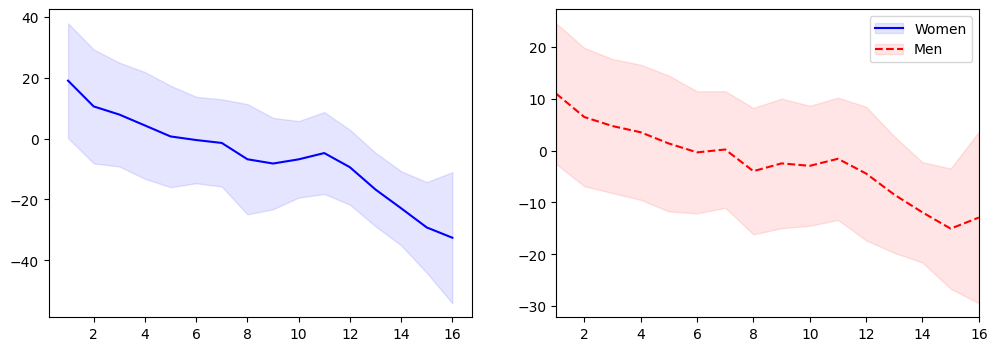

In [18]:
# let's see if __seed__ is predictive for predicting the point difference
tmpmean = tourney_data.pivot_table(columns="men_women", index="T1_seed", values="PointDiff", aggfunc="mean").ffill()
tmpstd = tourney_data.pivot_table(columns="men_women", index="T1_seed", values="PointDiff", aggfunc="std").ffill()
fig, axis = plt.subplots(ncols=2, figsize=(12, 4))
(line_1,) = axis[0].plot(tmpmean.index, tmpmean[0], "b-")
fill_1 = axis[0].fill_between(tmpmean.index, tmpmean[0] - tmpstd[0], tmpmean[0] + tmpstd[0], color="b", alpha=0.1)
(line_2,) = axis[1].plot(tmpmean.index, tmpmean[1], "r--")
fill_2 = axis[1].fill_between(tmpmean.index, tmpmean[1] - tmpstd[1], tmpmean[1] + tmpstd[1], color="r", alpha=0.1)
plt.margins(x=0)
plt.legend([(line_1, fill_1), (line_2, fill_2)], ["Women", "Men"])

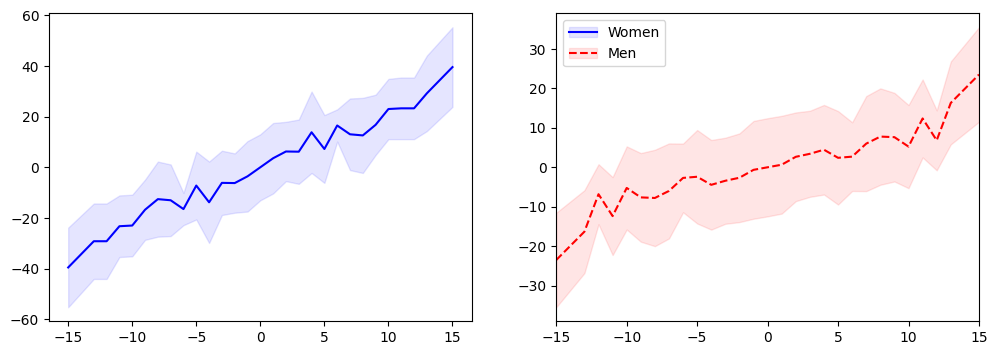

In [19]:
# let's see __seed difference__ is predictive for predicting the point difference
tmpmean = tourney_data.pivot_table(columns="men_women", index="Seed_diff", values="PointDiff", aggfunc="mean").ffill()
tmpstd = tourney_data.pivot_table(columns="men_women", index="Seed_diff", values="PointDiff", aggfunc="std").ffill()
fig, axis = plt.subplots(ncols=2, figsize=(12, 4))
(line_1,) = axis[0].plot(tmpmean.index, tmpmean[0], "b-")
fill_1 = axis[0].fill_between(tmpmean.index, tmpmean[0] - tmpstd[0], tmpmean[0] + tmpstd[0], color="b", alpha=0.1)
(line_2,) = axis[1].plot(tmpmean.index, tmpmean[1], "r--")
fill_2 = axis[1].fill_between(tmpmean.index, tmpmean[1] - tmpstd[1], tmpmean[1] + tmpstd[1], color="r", alpha=0.1)
plt.margins(x=0)
plt.legend([(line_1, fill_1), (line_2, fill_2)], ["Women", "Men"])

## <<- Medium difficulty features ->>

In [20]:
# box score columns, for which we want features to our model
boxcols = [
    "T1_Score", "T1_FGM", "T1_FGA", "T1_FGM3", "T1_FGA3", "T1_FTM", "T1_FTA",
    "T1_OR", "T1_DR", "T1_Ast", "T1_TO", "T1_Stl", "T1_Blk", "T1_PF",
    "T2_Score", "T2_FGM", "T2_FGA", "T2_FGM3", "T2_FGA3", "T2_FTM", "T2_FTA",
    "T2_OR", "T2_DR", "T2_Ast", "T2_TO", "T2_Stl", "T2_Blk", "T2_PF",
    "PointDiff",
]

#### 1. Let's define a single match {**`T`**, **`OPP`**}. This means that **`T=TEAM(x)`** plays against an opponent team **`OPP=TEAM(y1)`**
#### 2. During regular season, team **`T`** plays multiple games {**`T`**, **`OPP1`**}, {**`T`**, **`OPP2`**}, ...; against different opponents **`OPP1=TEAM(y1)`**, **`OPP2=TEAM(y2)`**, ...
#### 3. We can calculate regular season average performance for the team **`T`** : **`average[T]`**
#### 4. We can also calculate how opponents perform on average when they play a game against team **`T`** : **`average[T_OPP1,T_OPP2,...]`**
#### 5. Let's play a new match: {**`T1`**, **`T2`**}
#### 6. We can collect performance data for the **`T1`**: **`average[T1]`** and **`average[T1_OPP1,T1_OPP2,...]`**
#### 7. We can collect performance data for the **`T2`**: **`average[T2]`** and **`average[T2_OPP1,T2_OPP2,...]`**
#### 8. Then we can combine all data: **`average[T1]`**,**`average[T1_OPP1,T1_OPP2,...]`**, **`average[T2]`**, **`average[T2_OPP1,T2_OPP2,...]`**
#### 9. Use this data to predict the output of a match between **`T1`** and **`T2`**

In [21]:
# calculate season averages
ss = regular_data.groupby(["Season", "T1_TeamID"])[boxcols].agg("mean").reset_index()

ss_T1 = ss.copy()
ss_T1.columns = ["T1_avg_" + x.replace("T1_", "").replace("T2_", "opponent_") for x in list(ss_T1.columns)]
ss_T1 = ss_T1.rename({"T1_avg_Season": "Season", "T1_avg_TeamID": "T1_TeamID"}, axis=1)
ss_T2 = ss.copy()
ss_T2.columns = ["T2_avg_" + x.replace("T1_", "").replace("T2_", "opponent_") for x in list(ss_T2.columns)]
ss_T2 = ss_T2.rename({"T2_avg_Season": "Season", "T2_avg_TeamID": "T2_TeamID"}, axis=1)

tourney_data = pd.merge(tourney_data, ss_T1, on=["Season", "T1_TeamID"], how="left")
tourney_data = pd.merge(tourney_data, ss_T2, on=["Season", "T2_TeamID"], how="left")
tourney_data

,Season,T1_TeamID,T2_TeamID,PointDiff,win,men_women,T1_seed,T2_seed,Seed_diff,T1_avg_Score,T1_avg_FGM,T1_avg_FGA,T1_avg_FGM3,T1_avg_FGA3,T1_avg_FTM,T1_avg_FTA,T1_avg_OR,T1_avg_DR,T1_avg_Ast,T1_avg_TO,T1_avg_Stl,T1_avg_Blk,T1_avg_PF,T1_avg_opponent_Score,T1_avg_opponent_FGM,T1_avg_opponent_FGA,T1_avg_opponent_FGM3,T1_avg_opponent_FGA3,T1_avg_opponent_FTM,T1_avg_opponent_FTA,T1_avg_opponent_OR,T1_avg_opponent_DR,T1_avg_opponent_Ast,T1_avg_opponent_TO,T1_avg_opponent_Stl,T1_avg_opponent_Blk,T1_avg_opponent_PF,T1_avg_PointDiff,T2_avg_Score,T2_avg_FGM,T2_avg_FGA,T2_avg_FGM3,T2_avg_FGA3,T2_avg_FTM,T2_avg_FTA,T2_avg_OR,T2_avg_DR,T2_avg_Ast,T2_avg_TO,T2_avg_Stl,T2_avg_Blk,T2_avg_PF,T2_avg_opponent_Score,T2_avg_opponent_FGM,T2_avg_opponent_FGA,T2_avg_opponent_FGM3,T2_avg_opponent_FGA3,T2_avg_opponent_FTM,T2_avg_opponent_FTA,T2_avg_opponent_OR,T2_avg_opponent_DR,T2_avg_opponent_Ast,T2_avg_opponent_TO,T2_avg_opponent_Stl,T2_avg_opponent_Blk,T2_avg_opponent_PF,T2_avg_PointDiff
0,2003,1421,1411,7.111111,1,1,16,16,0,69.615326,23.847510,55.639847,6.348659,17.658238,15.571648,20.428352,12.011494,22.652874,12.740230,15.931034,6.927969,2.937165,18.769349,76.947893,27.242146,59.712644,7.459004,20.307280,15.004598,22.157854,13.463602,22.401533,15.563218,12.568582,8.679693,4.141762,18.265134,-7.332567,72.533333,24.644444,55.051852,5.911111,18.437037,17.333333,27.929630,13.103704,24.677778,14.140741,15.166667,6.407407,2.222222,18.211111,70.585185,25.581481,60.140741,7.507407,23.051852,11.914815,18.655556,11.881481,22.781481,13.718519,14.259259,7.977778,2.596296,21.533333,1.948148
1,2003,1112,1436,29.000000,1,1,1,16,15,84.511905,30.067460,65.087302,6.984127,19.857143,17.392857,24.813492,15.051587,27.440476,17.488095,14.666667,8.396825,4.186508,17.587302,69.531746,26.115079,64.107143,6.253968,19.797619,11.047619,17.503968,12.980159,23.067460,15.341270,16.738095,5.904762,2.369048,21.888889,14.980159,67.255172,24.634483,55.427586,5.241379,15.310345,12.744828,19.379310,12.903448,25.565517,14.096552,13.993103,6.841379,2.958621,15.703448,62.565517,22.600000,54.696552,7.034483,21.344828,10.331034,15.482759,9.517241,21.641379,13.158621,12.910345,7.082759,3.655172,17.772414,4.689655
2,2003,1113,1272,13.000000,1,1,10,7,-3,75.344828,27.003831,56.436782,3.977011,12.475096,17.360153,25.877395,13.501916,23.111111,15.448276,13.881226,5.164751,4.191571,19.260536,68.574713,24.574713,55.176245,5.398467,15.766284,14.026820,20.375479,10.931034,20.367816,13.946360,15.402299,5.950192,3.908046,22.624521,6.770115,74.210728,26.183908,59.762452,6.969349,19.996169,14.873563,22.766284,14.019157,25.846743,16.555556,13.739464,7.363985,5.042146,18.693487,65.517241,23.164751,57.593870,5.854406,18.218391,13.333333,20.659004,12.295019,23.482759,13.237548,15.019157,7.252874,3.153257,19.827586,8.693487
3,2003,1141,1166,6.000000,1,1,11,6,-5,79.344828,26.620690,52.689655,6.827586,17.931034,19.275862,25.172414,10.586207,23.275862,15.620690,18.241379,7.103448,4.000000,20.965517,73.241379,26.344828,57.931034,4.965517,13.896552,15.586207,21.965517,12.241379,18.896552,11.793103,16.068966,8.448276,2.482759,21.689655,6.103448,79.006734,28.619529,57.289562,7.942761,20.424242,13.824916,19.952862,10.848485,23.097643,16.784512,13.309764,8.370370,4.427609,17.205387,64.107744,23.797980,55.148148,4.868687,14.282828,11.643098,16.619529,11.020202,21.289562,12.329966,17.006734,6.306397,2.569024,19.323232,14.898990
4,2003,1143,1301,1.777778,1,1,8,9,1,73.636015,27.015326,57.946360,6.314176,16.789272,13.291188,19.371648,11.114943,24.095785,15.816092,14.019157,6.455939,2.758621,16.888889,68.923372,25.072797,58.114943,7.034483,21.237548,11.743295,17.214559,11.049808,22.659004,15.881226,14.708812,5.865900,2.482759,18.919540,4.712644,72.122222,24.248148,53.129630,7.940741,22.429630,15.685185,20.385185,9.700000,21.907407,14.614815,14.129630,7.737037,3.048148,18.603704,67.751852,23.337037,52.925926,5.703704,16.903704,15.374074,21.129630,10.514815,21.348148,12.511111,14.581481,7.418519,2.811111,19.262963,4.370370

## <<- Hard difficulty features ->>

![chess](https://preview.redd.it/rapid-elo-distribution-september-2023-v0-ebk9mbac3cpb1.png?width=1080&crop=smart&auto=webp&s=a1dfc1d91c06cc3f96229a7a0f9c89ffc3bba2ef)

In [22]:
def update_elo(winner_elo, loser_elo):
    expected_win = expected_result(winner_elo, loser_elo)
    change_in_elo = k_factor * (1 - expected_win)
    winner_elo += change_in_elo
    loser_elo -= change_in_elo
    return winner_elo, loser_elo


def expected_result(elo_a, elo_b):
    return 1.0 / (1 + 10 ** ((elo_b - elo_a) / elo_width))

base_elo = 1000
elo_width = 400
k_factor = 100

elos = []
for season in sorted(set(seeds["Season"])):
    ss = regular_data.loc[regular_data["Season"] == season]
    ss = ss.loc[ss["win"] == 1].reset_index(drop=True)
    teams = set(ss["T1_TeamID"]) | set(ss["T2_TeamID"])
    elo = dict(zip(teams, [base_elo] * len(teams)))
    for i in range(ss.shape[0]):
        w_team, l_team = ss.loc[i, "T1_TeamID"], ss.loc[i, "T2_TeamID"]
        w_elo, l_elo = elo[w_team], elo[l_team]
        w_elo_new, l_elo_new = update_elo(w_elo, l_elo)
        elo[w_team] = w_elo_new
        elo[l_team] = l_elo_new
    elo = pd.DataFrame.from_dict(elo, orient="index").reset_index()
    elo = elo.rename({"index": "TeamID", 0: "elo"}, axis=1)
    elo["Season"] = season
    elos.append(elo)
elos = pd.concat(elos)

elos_T1 = elos.copy().rename({"TeamID": "T1_TeamID", "elo": "T1_elo"}, axis=1)
elos_T2 = elos.copy().rename({"TeamID": "T2_TeamID", "elo": "T2_elo"}, axis=1)
tourney_data = pd.merge(tourney_data, elos_T1, on=["Season", "T1_TeamID"], how="left")
tourney_data = pd.merge(tourney_data, elos_T2, on=["Season", "T2_TeamID"], how="left")
tourney_data["elo_diff"] = tourney_data["T1_elo"] - tourney_data["T2_elo"]

<Axes: xlabel='elo'>

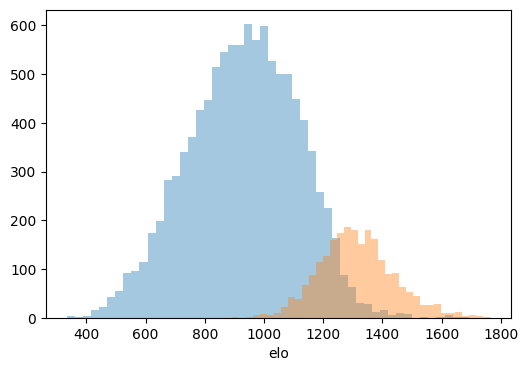

In [23]:
tmp = pd.merge(elos, tourney_data[['Season', 'T1_TeamID']].drop_duplicates(), 
               left_on = ['Season', 'TeamID'], 
               right_on = ['Season', 'T1_TeamID'],
               how = 'left')

plt.figure(figsize=(6,4))
seaborn.distplot(tmp.loc[pd.isnull(tmp['T1_TeamID']),'elo'], kde=False)
seaborn.distplot(tmp.loc[~pd.isnull(tmp['T1_TeamID']),'elo'], kde=False)

<Axes: xlabel='T1_seed', ylabel='T1_elo'>

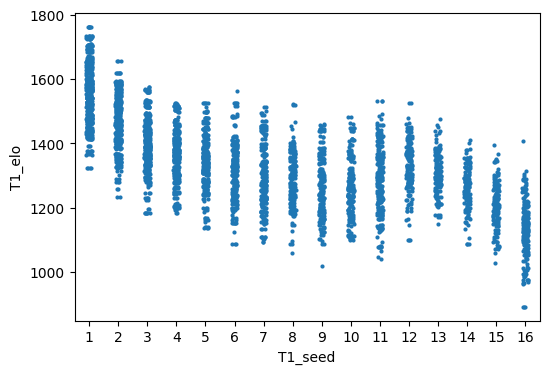

In [24]:
plt.figure(figsize=(6,4))
seaborn.stripplot(data = tourney_data, y = 'T1_elo', x = 'T1_seed', size=3)

<Axes: xlabel='Seed_diff', ylabel='elo_diff'>

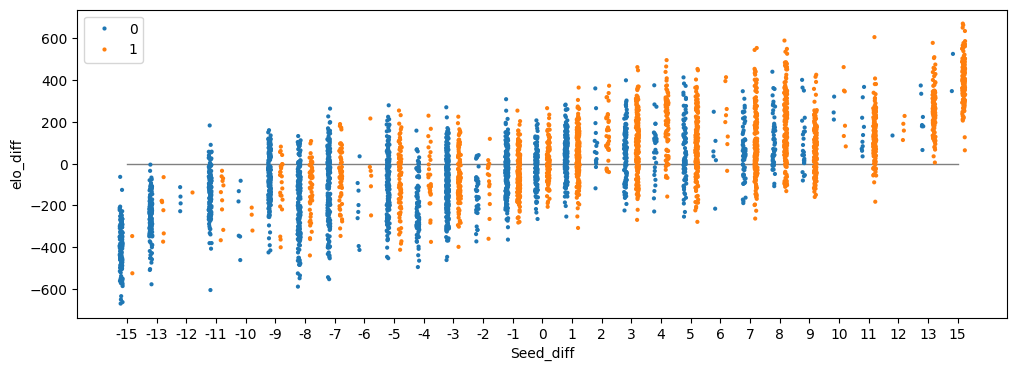

In [25]:
plt.figure(figsize=(12,4))
seaborn.stripplot(data = tourney_data, y = 'elo_diff', x = 'Seed_diff', hue='win', dodge=True, size=3)
seaborn.lineplot([0]*29,color='gray',lw = 1)

## <<- Hardest difficulty features ->>

![exponent](https://media1.shmoop.com/images/algebra/alg_fn_nonlin_narr_graphik_30.png)

In [26]:
import statsmodels.api as sm
import tqdm

regular_data["ST1"] = regular_data.apply(lambda t: str(int(t["Season"])) + "/" + str(int(t["T1_TeamID"])), axis=1)
regular_data["ST2"] = regular_data.apply(lambda t: str(int(t["Season"])) + "/" + str(int(t["T2_TeamID"])), axis=1)
seeds_T1["ST1"] = seeds_T1.apply(lambda t: str(int(t["Season"])) + "/" + str(int(t["T1_TeamID"])), axis=1)
seeds_T2["ST2"] = seeds_T2.apply(lambda t: str(int(t["Season"])) + "/" + str(int(t["T2_TeamID"])), axis=1)

# collect tourney teams
st = set(seeds_T1["ST1"]) | set(seeds_T2["ST2"])
# append non-tourney teams which were able to beat tourney team at least once
st = st | set(regular_data.loc[(regular_data["T1_Score"] > regular_data["T2_Score"]) & 
                               (regular_data["ST2"].isin(st)), "ST1"])

def team_quality(season, men_women):
    # mixed effects: fixed intercept=0, random slope
    formula = "PointDiff~-1+T1_TeamID+T2_TeamID"
    glm = sm.GLM.from_formula(
        formula=formula,
        data=dt.loc[(dt["Season"] == season) & (dt["men_women"] == men_women), :],
        family=sm.families.Gaussian(),
    ).fit()
    
    quality = pd.DataFrame(glm.params).reset_index()
    quality.columns = ["TeamID", "quality"]
    quality["quality"] = quality["quality"]
    quality["Season"] = season
    quality = quality.loc[quality.TeamID.str.contains("T1_")].reset_index(drop=True)
    quality["TeamID"] = quality["TeamID"].apply(lambda x: x[10:14]).astype(int)
    return quality


glm_quality = []

dt = regular_data.loc[regular_data["ST1"].isin(st) | regular_data["ST2"].isin(st)]
dt["T1_TeamID"] = dt["T1_TeamID"].astype(str)
dt["T2_TeamID"] = dt["T2_TeamID"].astype(str)
dt.loc[~dt["ST1"].isin(st), "T1_TeamID"] = "0000"
dt.loc[~dt["ST2"].isin(st), "T2_TeamID"] = "0000"
seasons = sorted(set(seeds["Season"]))
for s in tqdm.tqdm(seasons, unit="season"):
    if s >= 2010:  # min season for women
        glm_quality.append(team_quality(s, 0))
    if s >= 2003:  # min season for men
        glm_quality.append(team_quality(s, 1))

glm_quality = pd.concat(glm_quality).reset_index(drop=True)

glm_quality_T1 = glm_quality.copy()
glm_quality_T2 = glm_quality.copy()
glm_quality_T1.columns = ["T1_TeamID", "T1_quality", "Season"]
glm_quality_T2.columns = ["T2_TeamID", "T2_quality", "Season"]
tourney_data = pd.merge(tourney_data, glm_quality_T1, on=["Season", "T1_TeamID"], how="left")
tourney_data = pd.merge(tourney_data, glm_quality_T2, on=["Season", "T2_TeamID"], how="left")
tourney_data["diff_quality"] = tourney_data["T1_quality"] - tourney_data["T2_quality"]

100%|██████████| 22/22 [01:42<00:00,  4.64s/season]


<Axes: ylabel='T1_quality'>

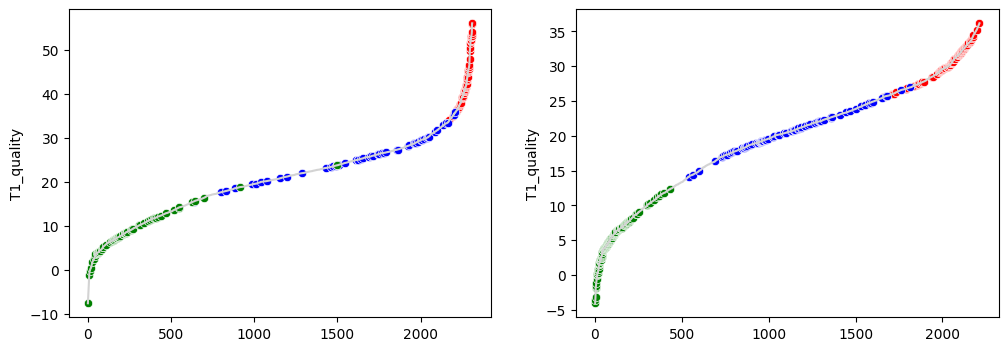

In [27]:
tmp = (
    tourney_data[["Season", "men_women", "T1_seed", "T1_quality"]]
    .drop_duplicates()
    .sort_values("T1_quality")
    .reset_index(drop=True)
)

fig, axs = plt.subplots(ncols=2, figsize=(12, 4))

seaborn.lineplot(tmp.loc[tmp["men_women"] == 0, "T1_quality"], color="lightgray", ax=axs[0])
seaborn.scatterplot(tmp.loc[(tmp["men_women"] == 0) & (tmp.T1_seed == 1), "T1_quality"], color="red", ax=axs[0])
seaborn.scatterplot(tmp.loc[(tmp["men_women"] == 0) & (tmp.T1_seed == 7), "T1_quality"], color="blue", ax=axs[0])
seaborn.scatterplot(tmp.loc[(tmp["men_women"] == 0) & (tmp.T1_seed == 16), "T1_quality"], color="green", ax=axs[0])

seaborn.lineplot(tmp.loc[tmp["men_women"] == 1, "T1_quality"], color="lightgray", ax=axs[1])
seaborn.scatterplot(tmp.loc[(tmp["men_women"] == 1) & (tmp.T1_seed == 1), "T1_quality"], color="red", ax=axs[1])
seaborn.scatterplot(tmp.loc[(tmp["men_women"] == 1) & (tmp.T1_seed == 7), "T1_quality"], color="blue", ax=axs[1])
seaborn.scatterplot(tmp.loc[(tmp["men_women"] == 1) & (tmp.T1_seed == 16), "T1_quality"], color="green", ax=axs[1])

In [28]:
tmp["QualitySeed"] = (
    (tmp.groupby(["Season", "men_women"])["T1_quality"].rank(ascending=False) // 4 + 1).clip(1, 16).astype(int)
)
pd.pivot_table(data=tmp, index="T1_seed", columns="QualitySeed", values="men_women", aggfunc="count").fillna(0).astype(int).style.bar(color="#5fba7d", vmin=0, vmax=50)

QualitySeed,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
T1_seed,,,,,,,,,,,,,,,,
1,75,45,12,4,1,1,1,0,1,0,0,0,0,0,0,0
2,18,49,42,20,5,4,2,0,0,0,0,0,0,0,0,0
3,6,16,33,30,26,16,5,3,0,4,1,0,0,0,0,0
4,5,15,22,25,18,21,19,9,3,2,1,0,0,0,0,0
5,0,6,14,25,20,19,22,14,7,4,7,2,0,0,0,0
6,1,3,7,13,23,29,14,19,10,10,6,4,1,0,0,0
7,0,2,3,6,18,12,19,22,22,14,12,8,2,0,0,0
8,0,0,3,6,6,17,19,20,19,22,15,6,7,0,0,0
9,0,2,0,6,10,7,12,17,25,24,19,11,5,1,1,0


In [29]:
from sklearn.metrics import roc_auc_score

print("Seed AUC    :", np.round(roc_auc_score(1 - tourney_data["win"], tourney_data["T1_seed"] - tourney_data["T2_seed"]), 3))
print("Quality AUC :", np.round(roc_auc_score(tourney_data["win"], tourney_data["T1_quality"] - tourney_data["T2_quality"]), 3))

Seed AUC    : 0.807
Quality AUC : 0.825


In [30]:
# who is better, experts or statistics, by season
for s in sorted(set(tourney_data['Season'])):
    st = tourney_data['Season'] == s
    print(s, 
          a:=np.round(roc_auc_score(1-tourney_data.loc[st, "win"],tourney_data.loc[st, 'T1_seed'] - tourney_data.loc[st, 'T2_seed']),3),
          b:=np.round(roc_auc_score(tourney_data.loc[st, "win"],tourney_data.loc[st, 'T1_quality'] - tourney_data.loc[st, 'T2_quality']),3),
          np.where(a>b, '', 'Q')
         )

2003 0.807 0.779 
2004 0.823 0.81 
2005 0.792 0.811 Q
2006 0.75 0.781 Q
2007 0.902 0.838 
2008 0.817 0.851 Q
2009 0.84 0.843 Q
2010 0.804 0.808 Q
2011 0.789 0.816 Q
2012 0.828 0.855 Q
2013 0.792 0.819 Q
2014 0.779 0.816 Q
2015 0.85 0.87 Q
2016 0.787 0.825 Q
2017 0.842 0.851 Q
2018 0.786 0.794 Q
2019 0.85 0.88 Q
2021 0.78 0.818 Q
2022 0.77 0.794 Q
2023 0.781 0.793 Q
2024 0.839 0.839 Q


## <<- Machine Learning model ->>

In [31]:
features = [
    ### EASY FEATURES ###
    "men_women",    
    "T1_seed",
    "T2_seed",
    "Seed_diff",
    ### MEDIUM FEATURES ###
    "T1_avg_Score",
    #"T1_avg_FGM",
    "T1_avg_FGA",
    #"T1_avg_FGM3",
    #"T1_avg_FGA3",
    #"T1_avg_FTM",
    #"T1_avg_FTA",
    #"T1_avg_OR",
    #"T1_avg_DR",
    #"T1_avg_Ast",
    #"T1_avg_TO",
    #"T1_avg_Stl",
    "T1_avg_Blk",
    "T1_avg_PF",
    #"T1_avg_opponent_Score",
    #"T1_avg_opponent_FGM",
    "T1_avg_opponent_FGA",
    #"T1_avg_opponent_FGM3",
    #"T1_avg_opponent_FGA3",
    #"T1_avg_opponent_FTM",
    #"T1_avg_opponent_FTA",
    #"T1_avg_opponent_OR",
    #"T1_avg_opponent_DR",
    #"T1_avg_opponent_Ast",
    #"T1_avg_opponent_TO",
    #"T1_avg_opponent_Stl",
    "T1_avg_opponent_Blk",
    "T1_avg_opponent_PF",
    "T1_avg_PointDiff",
    "T2_avg_Score",
    #"T2_avg_FGM",
    "T2_avg_FGA",
    #"T2_avg_FGM3",
    #"T2_avg_FGA3",
    #"T2_avg_FTM",
    #"T2_avg_FTA",
    #"T2_avg_OR",
    #"T2_avg_DR",
    #"T2_avg_Ast",
    #"T2_avg_TO",
    #"T2_avg_Stl",
    "T2_avg_Blk",
    "T2_avg_PF",
    #"T2_avg_opponent_Score",
    #"T2_avg_opponent_FGM",
    "T2_avg_opponent_FGA",
    #"T2_avg_opponent_FGM3",
    #"T2_avg_opponent_FGA3",
    #"T2_avg_opponent_FTM",
    #"T2_avg_opponent_FTA",
    #"T2_avg_opponent_OR",
    #"T2_avg_opponent_DR",
    #"T2_avg_opponent_Ast",
    #"T2_avg_opponent_TO",
    #"T2_avg_opponent_Stl",
    "T2_avg_opponent_Blk",
    "T2_avg_opponent_PF",
    "T2_avg_PointDiff",
    ### HARD FEATURES ###
    "T1_elo",
    "T2_elo",    
    "elo_diff",
    ### HARDEST FEATURES ###
    "T1_quality",
    "T2_quality",
]

print(f"Number of features {len(features)}")

Number of features 25


In [32]:
import xgboost as xgb

param = {}
param["objective"] = "reg:squarederror"
param["booster"] = "gbtree"
param["eta"] = 0.01
param["subsample"] = 0.6
param["colsample_bynode"] = 0.8
param["num_parallel_tree"] = 2
param["min_child_weight"] = 4
param["max_depth"] = 4
param["tree_method"] = "hist"
param['grow_policy'] = 'lossguide'
param["max_bin"] = 32

num_rounds = 700

![crossvalidation](https://miro.medium.com/v2/resize:fit:940/1*lOZqYqwmuW1lg6fitwqXxA.png)

In [33]:
from sklearn.metrics import mean_absolute_error, brier_score_loss

models = {}
oof_mae = []
oof_preds = []
oof_targets = []
oof_ss = []

# leave-one-season out models
for oof_season in set(tourney_data.Season):
    x_train = tourney_data.loc[tourney_data["Season"] != oof_season, features].values
    y_train = tourney_data.loc[tourney_data["Season"] != oof_season, "PointDiff"].values
    x_val = tourney_data.loc[tourney_data["Season"] == oof_season, features].values
    y_val = tourney_data.loc[tourney_data["Season"] == oof_season, "PointDiff"].values
    s_val = tourney_data.loc[tourney_data["Season"] == oof_season, "Season"].values
    
    dtrain = xgb.DMatrix(x_train, label=y_train)
    dval = xgb.DMatrix(x_val, label=y_val)
    models[oof_season] = xgb.train(
        params=param,
        dtrain=dtrain,
        num_boost_round = num_rounds,        
    )
    preds = models[oof_season].predict(dval)
    print(f"oof season {oof_season} mae: {mean_absolute_error(y_val, preds)}")
    oof_mae.append(mean_absolute_error(y_val, preds))
    oof_preds += list(preds)
    oof_targets += list(y_val)
    oof_ss += list(s_val)
    
print(f"average mae: {np.mean(oof_mae)}")

oof season 2003 mae: 8.83583841972674
oof season 2004 mae: 7.877172475418936
oof season 2005 mae: 7.809822350962916
oof season 2006 mae: 8.715039485028845
oof season 2007 mae: 7.697273194704515
oof season 2008 mae: 9.851162636536174
oof season 2009 mae: 9.290758834324919
oof season 2010 mae: 8.807893125155465
oof season 2011 mae: 9.954359813793602
oof season 2012 mae: 8.335852308988443
oof season 2013 mae: 9.840493644298906
oof season 2014 mae: 10.172402656786382
oof season 2015 mae: 7.873326234710523
oof season 2016 mae: 10.133262117875613
oof season 2017 mae: 9.975200487682836
oof season 2018 mae: 10.354635356241662
oof season 2019 mae: 8.85319754924052
oof season 2021 mae: 10.519632193252676
oof season 2022 mae: 10.594619076525419
oof season 2023 mae: 9.627004365824398
oof season 2024 mae: 9.434912256163253
average mae: 9.264469456344893


<Axes: xlabel='pred_pointdiff', ylabel='average_win_pct'>

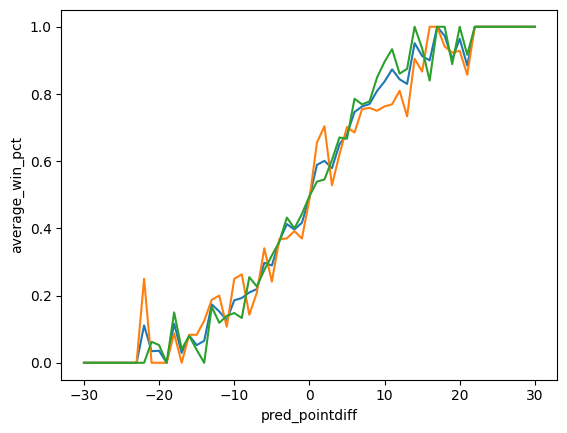

In [34]:
df = pd.DataFrame(
    {"Season": oof_ss, "pred": oof_preds, "label": [(t > 0) * 1 for t in oof_targets], "men_women": tourney_data["men_women"]}
)
df["pred_pointdiff"] = df["pred"].astype(int)

xdf_all = df.clip(-30, 30).groupby("pred_pointdiff")["label"].mean().reset_index(name="average_win_pct")
xdf_men = df.clip(-30, 30).loc[df["men_women"] == 0].groupby("pred_pointdiff")["label"].mean().reset_index(name="average_win_pct")
xdf_women = df.clip(-30, 30).loc[df["men_women"] == 1].groupby("pred_pointdiff")["label"].mean().reset_index(name="average_win_pct")

seaborn.lineplot(x=xdf_all["pred_pointdiff"], y=xdf_all["average_win_pct"])
seaborn.lineplot(x=xdf_men["pred_pointdiff"], y=xdf_men["average_win_pct"])
seaborn.lineplot(x=xdf_women["pred_pointdiff"], y=xdf_women["average_win_pct"])

brier: 0.16815077845524765


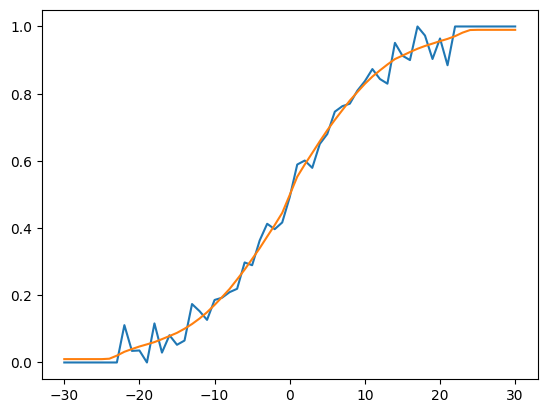

In [35]:
from scipy.interpolate import UnivariateSpline

t = 25
dat = list(zip(oof_preds, np.array(oof_targets)>0))
dat = sorted(dat, key = lambda x: x[0])
pred, label = list(zip(*dat))
spline_model = UnivariateSpline(np.clip(pred, -t, t), label, k=5)
spline_fit = np.clip(spline_model(np.clip(oof_preds, -t, t)), 0.01, 0.99)
print(f"brier: {brier_score_loss(np.array(oof_targets)>0, spline_fit)}")
df["spline"] = spline_fit
xdf = df.clip(-30,30).groupby('pred_pointdiff')[['spline','label']].mean().reset_index()

plt.figure()
plt.plot(xdf['pred_pointdiff'],xdf['label'])
plt.plot(xdf['pred_pointdiff'],xdf['spline'])

In [36]:
print(f"brier: {brier_score_loss(np.array(oof_targets)>0, spline_fit)}")

for oof_season in set(tourney_data.Season):
    x = df.loc[df["Season"] == oof_season, "spline"].values
    y = df.loc[df["Season"] == oof_season, "label"].values
    print(oof_season, np.round(brier_score_loss(y, x),5))

brier: 0.16815077845524765
2003 0.18264
2004 0.16867
2005 0.16873
2006 0.19097
2007 0.1427
2008 0.15476
2009 0.16833
2010 0.16682
2011 0.18403
2012 0.15271
2013 0.17138
2014 0.17734
2015 0.1444
2016 0.17107
2017 0.15983
2018 0.17787
2019 0.13968
2021 0.17755
2022 0.18839
2023 0.18659
2024 0.1558


## <<- Make submission ->>

In [37]:
##################################################################################
#### Stage2 data should be available on March 17, check forums for updates #######
##################################################################################

X = pd.read_csv(f"{data_dir}/SampleSubmissionStage2.csv")
X

,ID,Pred
0,2025_1101_1102,0.5
1,2025_1101_1103,0.5
2,2025_1101_1104,0.5
3,2025_1101_1105,0.5
4,2025_1101_1106,0.5
...,...,...
131402,2025_3477_3479,0.5
131403,2025_3477_3480,0.5
131404,2025_3478_3479,0.5
131405,2025_3478_3480,0.5


In [38]:
# construct dataframe for submission
X['Season'] = X['ID'].apply(lambda t: int(t.split('_')[0]))
X['T1_TeamID'] = X['ID'].apply(lambda t: int(t.split('_')[1]))
X['T2_TeamID'] = X['ID'].apply(lambda t: int(t.split('_')[2]))
X['men_women'] = X['T1_TeamID'].apply(lambda t: 0 if str(t)[0]=='1' else 1)
X = pd.merge(X, ss_T1, on = ['Season', 'T1_TeamID'], how = 'left')
X = pd.merge(X, ss_T2, on = ['Season', 'T2_TeamID'], how = 'left')
X = pd.merge(X, seeds_T1, on = ['Season', 'T1_TeamID'], how = 'left')
X = pd.merge(X, seeds_T2, on = ['Season', 'T2_TeamID'], how = 'left')
X = pd.merge(X, glm_quality_T1, on=["Season", "T1_TeamID"], how="left")
X = pd.merge(X, glm_quality_T2, on=["Season", "T2_TeamID"], how="left")
X = pd.merge(X, elos_T1, on=["Season", "T1_TeamID"], how="left")
X = pd.merge(X, elos_T2, on=["Season", "T2_TeamID"], how="left")
X["Seed_diff"] = X["T2_seed"] - X["T1_seed"]
X["elo_diff"] = X["T1_elo"] - X["T2_elo"]
X["diff_quality"] = X["T1_quality"] - X["T2_quality"]

In [39]:
# run models on given dataset
preds = []
for oof_season in set(tourney_data.Season):
    dtest = xgb.DMatrix(X[features].values)
    margin_preds = models[oof_season].predict(dtest) * 1.0 # aggressive submissions >1, conservative submissions <1
    probs = np.clip(spline_model(np.clip(margin_preds, -t, t)), 0.01, 0.99)
    preds.append(probs)
X['Pred'] = np.array(preds).mean(axis=0) 

In [40]:
# sanity check to check for seed matchup win probability distribution 
pd.pivot_table(data = X, index='T1_seed', columns='T2_seed', values='Pred', aggfunc='mean').style.bar(color='#5fba7d', vmin=0, vmax=1)

T2_seed,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000,10.000000,11.000000,12.000000,13.000000,14.000000,15.000000,16.000000
T1_seed,,,,,,,,,,,,,,,,
1.000000,0.496916,0.685229,0.747273,0.800315,0.839959,0.830092,0.851578,0.879037,0.889061,0.911429,0.913675,0.954763,0.979346,0.988564,0.989582,0.990000
2.000000,0.340248,0.551269,0.646753,0.714685,0.774480,0.762511,0.766502,0.803362,0.873406,0.833563,0.847682,0.871093,0.954076,0.961761,0.973799,0.986927
3.000000,0.176559,0.369540,0.520783,0.600502,0.658085,0.638901,0.688567,0.743522,0.752611,0.793364,0.790018,0.841734,0.872100,0.958534,0.950025,0.983792
4.000000,0.136894,0.322070,0.418173,0.540487,0.601285,0.600093,0.640089,0.709304,0.724548,0.716480,0.762950,0.798665,0.871410,0.916640,0.950819,0.979348
5.000000,0.116892,0.281827,0.365963,0.452715,0.502431,0.531360,0.584340,0.654936,0.673427,0.671419,0.670046,0.768626,0.841345,0.879938,0.881563,0.963951
6.000000,0.123890,0.296282,0.340484,0.431958,0.458949,0.499298,0.548635,0.617198,0.665353,0.661266,0.670877,0.732552,0.831382,0.875975,0.888293,0.931055
7.000000,0.083804,0.281595,0.340094,0.411002,0.451282,0.405689,0.506405,0.599252,0.616542,0.654878,0.667659,0.709315,0.762794,0.866621,0.874776,0.923847
8.000000,0.077232,0.254150,0.308596,0.363267,0.385535,0.372500,0.427254,0.490787,0.536494,0.572862,0.611890,0.658821,0.732350,0.789231,0.840591,0.870678
9.000000,0.066184,0.205274,0.265832,0.327020,0.350538,0.338635,0.388201,0.459167,0.507533,0.561100,0.587239,0.656515,0.730603,0.786131,0.800896,0.875038


In [41]:
X

,ID,Pred,Season,T1_TeamID,T2_TeamID,men_women,T1_avg_Score,T1_avg_FGM,T1_avg_FGA,T1_avg_FGM3,T1_avg_FGA3,T1_avg_FTM,T1_avg_FTA,T1_avg_OR,T1_avg_DR,T1_avg_Ast,T1_avg_TO,T1_avg_Stl,T1_avg_Blk,T1_avg_PF,T1_avg_opponent_Score,T1_avg_opponent_FGM,T1_avg_opponent_FGA,T1_avg_opponent_FGM3,T1_avg_opponent_FGA3,T1_avg_opponent_FTM,T1_avg_opponent_FTA,T1_avg_opponent_OR,T1_avg_opponent_DR,T1_avg_opponent_Ast,T1_avg_opponent_TO,T1_avg_opponent_Stl,T1_avg_opponent_Blk,T1_avg_opponent_PF,T1_avg_PointDiff,T2_avg_Score,T2_avg_FGM,T2_avg_FGA,T2_avg_FGM3,T2_avg_FGA3,T2_avg_FTM,T2_avg_FTA,T2_avg_OR,T2_avg_DR,T2_avg_Ast,T2_avg_TO,T2_avg_Stl,T2_avg_Blk,T2_avg_PF,T2_avg_opponent_Score,T2_avg_opponent_FGM,T2_avg_opponent_FGA,T2_avg_opponent_FGM3,T2_avg_opponent_FGA3,T2_avg_opponent_FTM,T2_avg_opponent_FTA,T2_avg_opponent_OR,T2_avg_opponent_DR,T2_avg_opponent_Ast,T2_avg_opponent_TO,T2_avg_opponent_Stl,T2_avg_opponent_Blk,T2_avg_opponent_PF,T2_avg_PointDiff,T1_seed,ST1,T2_seed,ST2,T1_quality,T2_quality,T1_elo,T2_elo,Seed_diff,elo_diff,diff_quality
0,2025_1101_1102,0.537056,2025,1101,1102,0,66.946360,23.977011,55.724138,4.049808,14.088123,14.942529,20.793103,8.567050,19.421456,12.367816,14.072797,9.946360,2.877395,21.264368,70.386973,23.436782,50.862069,5.398467,16.563218,18.114943,26.149425,8.681992,22.413793,12.099617,15.908046,7.823755,4.636015,17.605364,-3.440613,61.423611,21.097222,50.128472,8.013889,24.260417,11.215278,17.684028,5.881944,20.784722,13.267361,12.111111,5.614583,2.829861,17.701389,73.149306,26.218750,54.517361,7.184028,19.763889,13.527778,19.319444,7.868056,23.725694,12.777778,9.625000,6.767361,3.177083,17.291667,-11.725694,NaN,NaN,NaN,NaN,2.19672,NaN,962.681355,666.352733,NaN,296.328622,NaN
1,2025_1101_1103,0.761029,2025,1101,1103,0,66.946360,23.977011,55.724138,4.049808,14.088123,14.942529,20.793103,8.567050,19.421456,12.367816,14.072797,9.946360,2.877395,21.264368,70.386973,23.436782,50.862069,5.398467,16.563218,18.114943,26.149425,8.681992,22.413793,12.099617,15.908046,7.823755,4.636015,17.605364,-3.440613,83.708333,30.121528,63.850694,10.621528,28.975694,12.843750,17.142361,9.913194,24.770833,17.621528,11.701389,7.531250,3.708333,18.243056,75.628472,26.569444,61.121528,7.406250,23.239583,15.083333,20.666667,8.805556,21.510417,11.888889,11.954861,7.159722,2.406250,16.777778,8.079861,NaN,NaN,13.0,2025/1103,2.19672,11.381115,962.681355,1332.730427,NaN,-370.049072,-9.184395
2,2025_1101_1104,0.427268,2025,1101,1104,0,66.946360,23.977011,55.724138,4.049808,14.088123,14.942529,20.793103,8.567050,19.421456,12.367816,14.072797,9.946360,2.877395,21.264368,70.386973,23.436782,50.862069,5.398467,16.563218,18.114943,26.149425,8.681992,22.413793,12.099617,15.908046,7.823755,4.636015,17.605364,-3.440613,90.521886,30.898990,63.996633,10.363636,29.612795,18.360269,25.629630,10.885522,28.175084,16.680135,12.030303,6.030303,4.424242,18.878788,80.848485,28.710438,67.626263,7.309764,23.757576,16.117845,22.892256,10.276094,22.434343,12.558923,9.989899,7.764310,4.185185,20.649832,9.673401,NaN,NaN,2.0,2025/1104,2.19672,32.243481,962.681355,1457.909856,NaN,-495.228501,-30.046761
3,2025_1101_1105,0.549613,2025,1101,1105,0,66.946360,23.977011,55.724138,4.049808,14.088123,14.942529,20.793103,8.567050,19.421456,12.367816,14.072797,9.946360,2.877395,21.264368,70.386973,23.436782,50.862069,5.398467,16.563218,18.114943,26.149425,8.681992,22.413793,12.099617,15.908046,7.823755,4.636015,17.605364,-3.440613,68.136886,22.767677,58.836642,7.504006,24.442355,15.097527,22.645420,11.129572,19.657262,12.152212,14.750610,7.863811,3.704633,21.005921,78.613723,26.151167,55.543016,8.151167,20.881923,18.160223,25.878440,9.557994,23.971090,15.134796,13.920237,8.851968,2.968304,18.565308,-10.476837,NaN,NaN,NaN,NaN,2.19672,NaN,962.681355,585.765402,NaN,376.915953,NaN
4,2025_1101_1106,0.783191,2025,1101,1106,0,66.946360,23.977011,55.724138,4.049808,14.088123,14.942529,20.793103,8.567050,19.421456,12.367816,14.072797,9.946360,2.877395,21.264368,70.386973,23.436782,50.862069,5.

## Adding Goto Conversion Features

In [44]:
#Setup

import pandas as pd
year = 2025
kaggleFolderPath = '/Users/nicholasrichards/Desktop/march_madness_prediction_project/march-machine-learning-mania-' + str(year)
fivethirtyeightFolderPath = '/Users/nicholasrichards/Desktop/march_madness_prediction_project/538data'
#Mens Probability Matrix
#source: https://github.com/gotoConversion/goto_conversion
#Matrices were computed by converting betting odds to probabilities using goto_conversion

mensProbabilities_df = pd.read_csv(fivethirtyeightFolderPath + '/mensProbabilitiesTable.csv', index_col = 'player') #source: https://github.com/gotoConversion/goto_conversion
mensProbabilities_df = mensProbabilities_df.drop('Elo_Rating', axis=1)
#Womens Probability Matrix
#source: https://github.com/gotoConversion/goto_conversion
#Matrices were computed by converting betting odds to probabilities using goto_conversion

womensProbabilities_df = pd.read_csv(fivethirtyeightFolderPath + '/womensProbabilitiesTable.csv', index_col = 'player') #source: https://github.com/gotoConversion/goto_conversion
womensProbabilities_df = womensProbabilities_df.drop('Elo_Rating', axis=1)

In [45]:
#Import team seeds
mensTeamSeeds_df = pd.read_csv(kaggleFolderPath + '/MNCAATourneySeeds.csv')
mensTeamSeeds2025_df = mensTeamSeeds_df.iloc[[x == year for x in mensTeamSeeds_df['Season']]]
womensTeamSeeds_df = pd.read_csv(kaggleFolderPath + '/WNCAATourneySeeds.csv')
womensTeamSeeds2025_df = womensTeamSeeds_df.iloc[[x == year for x in womensTeamSeeds_df['Season']]]

In [68]:
#Implement Optimal Strategy
def get_roundOfMatch(team1, team2, seeds_df):

    slotMap = [1, 16, 8, 9, 5, 12, 4, 13, 6, 11, 3, 14, 7, 10, 2, 15]

    team1_seed = seeds_df.loc[[x == team1 for x in seeds_df['TeamID']],'Seed'].values[0]
    team2_seed = seeds_df.loc[[x == team2 for x in seeds_df['TeamID']],'Seed'].values[0]

    isFirstFourMatch = team1_seed[:3] == team2_seed[:3]
    if isFirstFourMatch:
        return 1

    team1_region = str(team1_seed[:1])
    team2_region = str(team2_seed[:1])

    team1_seedNumber = int(team1_seed[1:3]) #careful with first four teams
    team2_seedNumber = int(team2_seed[1:3]) #careful with first four teams

    isRegionSame = team1_region == team2_region
    if not isRegionSame:

        isTeam1_regionWX = team1_region in ['W','X']
        isTeam2_regionWX = team2_region in ['W','X']

        if isTeam1_regionWX and isTeam2_regionWX: #both W or X region
            return 6

        elif (not isTeam1_regionWX) and (not isTeam2_regionWX): #both not W or X region
            return 6

        else:
            return 7

    else: #same region

        team1_slot = slotMap.index(team1_seedNumber)
        team2_slot = slotMap.index(team2_seedNumber)

        isRound2 = (team1_slot // 2) == (team2_slot // 2)  #round of 64 or first four (not counted anyway)
        if isRound2:
            return 2

        isRound3 = (team1_slot // 4) == (team2_slot // 4)
        if isRound3: #yet to find why but "elif" throws error
            return 3

        isRound4 = (team1_slot // 8) == (team2_slot // 8)
        if isRound4: #yet to find why but "elif" throws error
            return 4

        else:
            return 5

def get_tourneyFlag(team1, team2, seeds_df):

    tourneyTeams = seeds_df['TeamID'].tolist()

    isTeam1InTourney = team1 in tourneyTeams
    isTeam2InTourney = team2 in tourneyTeams

    if isTeam1InTourney and isTeam2InTourney:
        return get_roundOfMatch(team1, team2, seeds_df)

    else:
        return 0

def get_flag_list(submission_df, mensTeamSeeds2025_df, womensTeamSeeds2025_df):
    flag_list = []
    for i in range(submission_df.shape[0]):

        currRow = submission_df.iloc[i,0].split('_')
        team1 = int(currRow[1])
        team2 = int(currRow[2])

        isWomensMatch = team1 + team2 > 6000
        if isWomensMatch:
            flag = get_tourneyFlag(team1, team2, womensTeamSeeds2025_df)
        else:
            flag = get_tourneyFlag(team1, team2, mensTeamSeeds2025_df)

        flag_list.append(flag)
    return flag_list

def set_optimalStrategy(submission_df, mensTeamSeeds2025_df, womensTeamSeeds2025_df, riskTeams, riskTeamToWinRounds):
    # Get the list of match round flags
    flag_list = get_flag_list(submission_df, mensTeamSeeds2025_df, womensTeamSeeds2025_df)

    # Ensure riskTeams and riskTeamToWinRounds correspond
    if len(riskTeams) != len(riskTeamToWinRounds):
        raise ValueError("The lengths of riskTeams and riskTeamToWinRounds must be the same")

    # Create a dictionary mapping team IDs to their winning round ranges
    risk_dict = dict(zip(riskTeams, riskTeamToWinRounds))

    # Iterate through each row in the submission file
    for i in range(submission_df.shape[0]):
        submission_row = submission_df.iloc[i, 0].split('_')
        submission_round = flag_list[i]

        team1 = int(submission_row[1])
        team2 = int(submission_row[2])

        # Check if team1 is in riskTeams
        if team1 in risk_dict:
            if (0 < submission_round) and (submission_round <= risk_dict[team1]):
                submission_df.at[i, 'Pred'] = 1.0  # team1 wins
                print(submission_df.iloc[i])

        # Check if team2 is in riskTeams
        elif team2 in risk_dict:
            if (0 < submission_round) and (submission_round <= risk_dict[team2]):
                submission_df.at[i, 'Pred'] = 0.0  # team2 wins
                print(submission_df.iloc[i])

    return submission_df

submission_df = pd.read_csv('/Users/nicholasrichards/Desktop/march_madness_prediction_project/538data/submission.csv')

riskTeams = [1179] 
riskTeamToWinRounds = [2]  
submission_df = set_optimalStrategy(submission_df, mensTeamSeeds2025_df, womensTeamSeeds2025_df, riskTeams, riskTeamToWinRounds)

# Define multiple risk teams and their winning round ranges
riskTeams = [1181, 1120, 1196, 1222, 3163, 3376] 
riskTeamToWinRounds = [6, 5, 5, 5, 6, 6]  

# Call the modified function
submission_df = set_optimalStrategy(submission_df, mensTeamSeeds2025_df, womensTeamSeeds2025_df, riskTeams, riskTeamToWinRounds)
submission_df.to_csv('XGBoost+Goto.csv', index=False)


ID      2025_1179_1281
Pred               1.0
Name: 23679, dtype: object
ID      2025_1103_1181
Pred               0.0
Name: 796, dtype: object
ID      2025_1104_1181
Pred               0.0
Name: 1156, dtype: object
ID      2025_1106_1120
Pred               0.0
Name: 1816, dtype: object
ID      2025_1110_1181
Pred               0.0
Name: 2941, dtype: object
ID      2025_1112_1181
Pred               0.0
Name: 3648, dtype: object
ID      2025_1116_1196
Pred               0.0
Name: 5065, dtype: object
ID      2025_1120_1136
Pred               1.0
Name: 6047, dtype: object
ID      2025_1120_1166
Pred               1.0
Name: 6076, dtype: object
ID      2025_1120_1235
Pred               1.0
Name: 6143, dtype: object
ID      2025_1120_1252
Pred               1.0
Name: 6160, dtype: object
ID      2025_1120_1257
Pred               1.0
Name: 6165, dtype: object
ID      2025_1120_1266
Pred               1.0
Name: 6174, dtype: object
ID      2025_1120_1276
Pred               1.0
Name: 6184, dtype:

In [66]:
submission_df

,ID,Pred
0,2025_1101_1102,0.5
1,2025_1101_1103,0.5
2,2025_1101_1104,0.5
3,2025_1101_1105,0.5
4,2025_1101_1106,0.5
...,...,...
131402,2025_3477_3479,0.5
131403,2025_3477_3480,0.5
131404,2025_3478_3479,0.5
131405,2025_3478_3480,0.5
